# <center> Logistic Regression to Amazon Fine Food Reviews Dataset</center>
___

###  <b>Exercise</b> :

1.	Download Amazon Fine Food Reviews dataset from Kaggle. You may have to create a Kaggle account to download data. (https://www.kaggle.com/snap/amazon-fine-food-reviews)
2.	Split data into train and test using time based slicing as 70%  train & 30% test.
3.	Perform featurization, BoW, tf-idf,Avg Word2Vec, tf-idf-Word2Vec.
4.	Apply GridsearchCV and RandomsearchCV on train data to find optimal lambda.
5.	Implement L1 and L2 regularizer to avoid overfitting or underfitting.
6.	Try L1 regularization, and keep increasing lambda, to calculate error and sparsity.
7.	Perform Multicollinearity-(Pertubation test) on features and show feature importance.(Add small epsilon to perform perturbation test)
8.	To test the performance of the model, calculate test error, train error, accuracy,precision,recall,F1-score,confusion matrix(TPR,TNR,FPR,FNR)
9.	Write your observations in English as crisply and unambiguously as possible. Always quantify your results.



### Information regarding data set :

1. <b>Title</b>: Amazon Fine Food Reviews Data

2. <b>Sources</b>: Stanford Network Analysis Project(SNAP)

3. <b>Relevant Information</b>: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~568,454 reviews up to October 2012(Oct 1999 - Oct 2012). Reviews include product and user information, ratings, and a plain text review.
4.  <b>Attribute Information</b>:   
    <b>ProductId </b>- unique identifier for the product <br/>
    <b>UserId </b>- unqiue identifier for the user <br/>
    <b>ProfileName </b>- name of the user <br/>
    <b>HelpfulnessNumerator </b>- number of users who found the review helpful <br/>
    <b>HelpfulnessDenominator </b>- number of users who indicated whether they found the review helpful or not <br/>
    <b>Score </b>- rating between 1 and 5.( rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored) <br/>
    <b>Time </b>- timestamp for the review <br/> 
    <b>Summary </b>- brief summary of the review <br/>
    <b>Text </b>- text of the review <br/>

---

### <b>Objective :</b> 
> <span style="color:blue">It is a 2-class classification task, where we have to analyze, transform(BoW,TF-IDF) and calculate probabilistic class label values using logistic regression, which evaluates whether a review is positive or negative.<span>

---


In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

import math
import random
import traceback
import sqlite3
import itertools
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report
from sklearn.metrics import make_scorer
from scipy.stats import uniform
from scipy.sparse import find
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import word2vec

### (1) Load dataset :

Dataset Shape : 
 (351237, 11)

Column Names: 
 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

Target Class label : 
positive    297807
negative     53430
Name: Score, dtype: int64



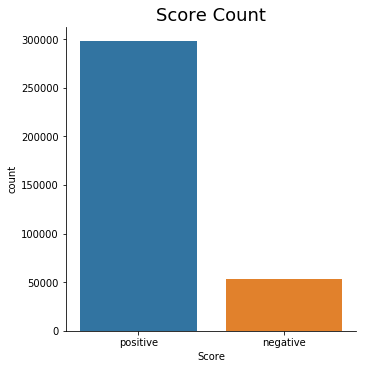

In [4]:
# This dataset is already gone through data deduplication and text preprocessing, so it is approx ~364K

# For Data Cleaning Steps follow this link -
# ipython notebook - https://drive.google.com/open?id=1JXCva5vXdIPgHbfNdD9sgnySqELoVtpy
# dataset - https://drive.google.com/open?id=1IoDoTT8TfDu53N6cyKg6xVCU-FDPHyIF

# For Text Preporcessing Steps follow this link -
# ipython notebook - https://drive.google.com/open?id=18-AkTzzEhCwM_hflIbDNBMAP-imX4k4i
# dataset - https://drive.google.com/open?id=1SfDwwXFhDpjgtfIE5O_E80SO89xRc8Sa

# Load 'finalDataSet.sqlite' in panda's daraframe.
reviews_df = load_review_dataset()

# Split data into train and test
x_train, x_test, y_train, y_test = perform_splitting(reviews_df['CleanedText'].values,reviews_df['Score'].values,0.3)

# Save data to disk for future reference
# joblib.dump(x_train, './raw_data/x_train_351237_X_1_by_7.joblib')
# joblib.dump(x_test, './raw_data/x_test_351237_X_1_by_3.joblib')
# joblib.dump(y_train, './raw_data/y_train_351237_X_1_by_7.joblib')
# joblib.dump(y_test, './raw_data/y_test_351237_X_1_by_3.joblib')

In [9]:
###--- All utility variables and functions(After importing all the necessary packages, always run this cell first.) ---###

# Regularization term : L1 and L2 Norm 
norms = ["L1","L2"]

# Values for hyperparameter lambda : C = 1 / lambda        
tuned_parameters = {'C': [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000]}

# Training Error
train_error = []

# Test Error
test_error = []

# Test Error
list_lambda = []

# Target Classes
target_classes = ["negative", "positive"]

def perform_splitting(train,test,test_size):
    '''
    This function splits data into given test_size
    '''
    # Split data into training and testing.
    return train_test_split(train,test,test_size=test_size,shuffle=False,random_state=0)     
    
def load_review_dataset():
    # Create connection object to load sqlite dataset
    connection = sqlite3.connect('finalDataSet.sqlite')

    # Load data into pandas dataframe.
    reviews_df = pd.read_sql_query(""" SELECT * FROM Reviews """,connection)

    # Drop index column 
    reviews_df = reviews_df.drop(columns=['index'])
    
    # Take sample of reviews
    # reviews_df = reviews_df.sample(3000)
        
    # Convert timestamp to datetime.
    reviews_df['Time'] = reviews_df[['Time']].applymap(lambda x: dt.datetime.fromtimestamp(x))

    # Sort the data on the basis of time.
    reviews_df = reviews_df.sort_values(by=['Time'])

    print("Dataset Shape : \n",reviews_df.shape)
    print("\nColumn Names: \n",reviews_df.columns)
    print("\nTarget Class label : ")
    print(reviews_df['Score'].value_counts())
    print()

    # Plot review counts
    plot_count_values(reviews_df)
    
    return reviews_df

def get_most_common_words(classifier,vectorizer,top_n=None):
    ''' Get top n values in row and return them with their corresponding feature names.'''
    print()
    class_labels = classifier.classes_
    feature_names =vectorizer.get_feature_names()
    top_positive_negative = sorted(zip(classifier.coef_[0], feature_names))
    top_values = zip(top_positive_negative[:top_n], top_positive_negative[:-(top_n+1):-1])
    
    complete_list = list()
    for (p_value,p_word),(n_value,n_word) in top_values:
        holder = []
        holder.append(n_word) 
        holder.append(n_value)
        holder.append(p_word)
        holder.append(p_value)                      
        complete_list.append(holder)       
    
    df = pd.DataFrame(complete_list,columns=['feature_positive', 'value_positive','feature_negative', 'value_negative'])  
    
    ptable = PrettyTable()
    ptable.title = "Feature Importance - {0} Most Common Features using absolute value of W".format(top_n)
    ptable.field_names = ['Feature (+ve)', '|W| (+ve)','Feature (-ve)', '|W| (-ve)']
    
    for row in df.itertuples():
        ptable.add_row([row.feature_positive,abs(row.value_positive),row.feature_negative,abs(row.value_negative)])
    
    print(ptable)
    print()


def perform_featurization(vectorizer_name, train=None, test=None):
    if vectorizer_name == "bow":        
        # Instantiate CountVectorizer
        bow_count_vectorizer = CountVectorizer()

        # Tokenize and build vocab
        bow_count_vectorizer.fit(train)

        # Encode document
        x_train_matrix = bow_count_vectorizer.transform(train)
        x_test_matrix = bow_count_vectorizer.transform(test)
        
        # Save data and bow vectorizer for later use.
        # joblib.dump(x_train_matrix, './matrix_data/bow/x_train_matrix_351237_X_1_by_7.joblib')
        # joblib.dump(x_test_matrix, './matrix_data/bow/x_test_matrix_351237_X_1_by_3.joblib')
        # joblib.dump(bow_count_vectorizer, './matrix_data/bow/bow_vectorizer_351237.joblib')
                
        return x_train_matrix,x_test_matrix,bow_count_vectorizer
    
    if vectorizer_name == "tf-idf":
        # Instantiate TfidfVectorizer
        tfidf_vectorizer = TfidfVectorizer(min_df = 3,ngram_range=(1,2))

        # Tokenize and build vocab
        tfidf_vectorizer.fit(train)

        # Encode document
        x_train_matrix = tfidf_vectorizer.transform(train)
        x_test_matrix = tfidf_vectorizer.transform(test)
        
        # Save data and tf-idf vectorizer for later use.
        # joblib.dump(x_train_matrix, './matrix_data/tfidf/x_train_matrix_351237_X_1_by_7.joblib')
        # joblib.dump(x_test_matrix, './matrix_data/tfidf/x_test_matrix_351237_X_1_by_3.joblib')
        # joblib.dump(tfidf_vectorizer, './matrix_data/tfidf/tf_idf_vectorizer_351237.joblib')
        
        return x_train_matrix,x_test_matrix,tfidf_vectorizer
    
    if vectorizer_name == "avg-w2v":
        # Create our own Word2Vec model from training data.
        
        # Make list of list from training data
        list_of_sentences_in_train=[]
        for sentence in train:
            list_of_sentences_in_train.append(sentence.split())
            
        # Make list of list from testing data - this will be useful when vectorizing testing data.
        list_of_sentences_in_test=[]
        for sentence in test:
            list_of_sentences_in_test.append(sentence.split())
            
        print("Shape of training data : ",train.shape)
        print("Shape of testing data : ",test.shape)
        print("Number of sentences present in training data : ",len(list_of_sentences_in_train))
        print("Number of sentences present in testing data : ",len(list_of_sentences_in_test))
        
        # Generate model
        w2v_model = Word2Vec(list_of_sentences_in_train,min_count=3,size=50, workers=6)
        
        # Train model on training dataset
        # w2v_model_train.train(list_of_sentences_in_train,total_examples=len(list_of_sentences_in_train), epochs=10)
        
        # List of word in vocabulary 
        w2v_words = list(w2v_model.wv.vocab)
        print("Length of vocabulary : ",len(w2v_words))

        # Save  Word2vec model to disk
        # w2v_model_train.wv.save_word2vec_format('./matrix_data/avgw2v/word2vec_vectorizer_351237_X_1_by_7.bin', binary=True)

        # Load Word2vec from disk
        # w2v_model = KeyedVectors.load_word2vec_format('./matrix_data/avgw2v/word2vec_vectorizer_351237_X_1_by_7.bin', binary=True)       
         
        # Prepare train vectorizer using trained word2vec model
        train_list = []
        for sentence in tqdm(list_of_sentences_in_train,unit=" sentence",desc='Average Word2Vec - Train data'):
            word_2_vec = np.zeros(50)
            cnt_words = 0
            for word in sentence:
                if word in w2v_words:
                    vec = w2v_model.wv[word]
                    word_2_vec += vec
                    cnt_words += 1
            if cnt_words != 0 :
                word_2_vec /= cnt_words
            train_list.append(word_2_vec)
        
        # Prepare test vectorizer using trained word2vec model
        test_list = []
        for sentence in tqdm(list_of_sentences_in_test,unit=" sentence",desc='Average Word2Vec - Test data'):
            word_2_vec = np.zeros(50)
            cnt_words = 0
            for word in sentence:
                if word in w2v_words:
                    vec = w2v_model.wv[word]
                    word_2_vec += vec
                    cnt_words += 1
            if cnt_words != 0 :
                word_2_vec /= cnt_words
            test_list.append(word_2_vec)
            
        avg_w2v_train = np.array(train_list)
        avg_w2v_test = np.array(test_list)
            
        # Save data for later use.
        # joblib.dump(avg_w2v_train, './matrix_data/avgw2v/x_train_matrix_351237_X_1_by_7.joblib')
        # joblib.dump(avg_w2v_test, './matrix_data/avgw2v/x_test_matrix_351237_X_1_by_3.joblib')
        
        return avg_w2v_train,avg_w2v_test
    
    if vectorizer_name == "tf-idf-w2v":
        # Make list of list from training data.      
        sentences_in_train=[]
        for sentence in train:
            sentences_in_train.append(sentence.split())
        
        # Make list of list from testing data - this will be useful when vectorizing testing data.
        sentences_in_test=[]
        for sentence in test:
            sentences_in_test.append(sentence.split())
            
        # Generate model
        w2v_model = Word2Vec(sentences_in_train,min_count=3,size=50, workers=6)
        
        # Instantiate TfidfVectorizer
        tfidf_vectorizer = TfidfVectorizer(min_df = 3,ngram_range=(1,2))

        # Tokenize and build vocab
        tfidf_vectorizer.fit(train)

        # Encode document
        x_train_matrix = tfidf_vectorizer.transform(train)
        
        # Get feature names
        feature_names = tfidf_vectorizer.get_feature_names()
        
        # Dictionary with word as a key, and the idf as a value
        dict_word_idf = dict(zip(feature_names, list(tfidf_vectorizer.idf_)))
        
                        
        # Load Word2vec from disk that we have already trained(on training data) and stored.
        # w2v_model = KeyedVectors.load_word2vec_format('./matrix_data/avgw2v/word2vec_vectorizer_351237_X_1_by_7.bin', binary=True)
        
        
        # Prepare train vectorizer using trained word2vec model        
        train_list = []
        row = 0
        for sentence in tqdm(sentences_in_train,unit=" sentence",desc='TF-IDF Weighted Word2Vec - Train data'):
            word_2_vec = np.zeros(50)
            weight_tfidf_sum = 0
            for word in sentence:
                try:
                    vec = w2v_model.wv[word]
                    # dict_word_idf[word] = idf value of word in whole courpus
                    # sentence.count(word) = tf valeus of word in this review
                    tfidf_value =  dict_word_idf[word]*sentence.count(word)
                    word_2_vec += (vec * tfidf_value)
                    weight_tfidf_sum += tfidf_value
                except:
                    pass
            if weight_tfidf_sum != 0:
                word_2_vec /= weight_tfidf_sum
            train_list.append(word_2_vec)
            row += 1
        
        # Prepare test vectorizer using trained word2vec model
        test_list = []
        row = 0
        for sentence in tqdm(sentences_in_test, unit=" sentence",desc='TF-IDF Weighted Word2Vec - Test data'):
            word_2_vec = np.zeros(50)
            weight_tfidf_sum = 0
            for word in sentence:
                try:
                    vec = w2v_model.wv[word]
                    # dict_word_idf[word] = idf value of word in whole courpus
                    # sentence.count(word) = tf valeus of word in this review
                    tfidf_value =  dict_word_idf[word]*sentence.count(word)
                    word_2_vec += (vec * tfidf_value)
                    weight_tfidf_sum += tfidf_value
                except:
                    pass
            if weight_tfidf_sum != 0:
                word_2_vec /= weight_tfidf_sum
            test_list.append(word_2_vec)
            row += 1
        
        tfidf_w2v_train = np.array(train_list)
        tfidf_w2v_test = np.array(test_list)
            
        # Save data for later use.
        # joblib.dump(tfidf_w2v_train, './matrix_data/tfidf-w2v/x_train_matrix_351237_X_1_by_7.joblib')
        # joblib.dump(tfidf_w2v_test, './matrix_data/tfidf-w2v/x_test_matrix_351237_X_1_by_3.joblib')
        
        return tfidf_w2v_train,tfidf_w2v_test   
    
def generate_report(optimal_alpha,testing_target,predicted_testing_target):
    '''
    This funtion generate reports like recall,precision,f1-score,confusion matrix.
    '''
    print()
    # Pretty table instance
    ptable = PrettyTable()
    ptable.title = "Classification Report with alpha = {0}".format(optimal_alpha)
    ptable.field_names = ["Class Lable/Averages","Precision", "Recall","F1-Score","Support"]
    report_dict = classification_report(testing_target, predicted_testing_target,output_dict = True)
    for key , value in report_dict.items():        
        inner_dict = value        
        ptable.add_row([key,inner_dict['precision'],inner_dict['recall'],inner_dict['f1-score'],inner_dict['support']])
    
    # Print pretty table values
    print(ptable)
        
    print()
    print("\nAccuracy Score: ",accuracy_score(testing_target, predicted_testing_target))
    test_error.append(1-accuracy_score(testing_target, predicted_testing_target))
    print()
    cnf_mat = confusion_matrix(testing_target, predicted_testing_target)
    plt.figure()
    plot_confusion_matrix(cnf_mat, classes=target_classes,title='Confusion Matrix')
    TN = cnf_mat[0,0]       
    FP = cnf_mat[0,1]  
    FN = cnf_mat[1,0]
    TP = cnf_mat[1,1]
    

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    
    # Specificity or true negative rate
    TNR = TN/(TN+FP)  
    
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    
    # False negative rate
    FNR = FN/(TP+FN)
    
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    print()
    # Pretty table instance
    ptable = PrettyTable()
    ptable.title = "Confusion Matrix Report"
    ptable.field_names = ['Term','Value']
    ptable.add_row(["TP (True Positive)",TP])
    ptable.add_row(["TN (True Negative)",TN])
    ptable.add_row(["FP (False Positive)",FP])
    ptable.add_row(["FN (False Negative)",FN])
    ptable.add_row(["TPR (True Positive Rate)= TP/(TP+FN))",TPR])
    ptable.add_row(["TNR (True Negative Rate)= TN/(TN+FP))",TNR])
    ptable.add_row(["FPR (False Positive Rate)= FP/(FP+TN))",FPR])
    ptable.add_row(["FNR (False Negative Rate)= FN/(TP+FN))",FNR])
    ptable.add_row(["ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN))",ACC])
    
    # Print pretty table values
    print(ptable) 
    
def plot_x_vs_y(x,y,x_label=None,y_label=None,title_name=None):    
    plt.plot(x, 
             y, 
             color='green', 
             linestyle='dashed', 
             linewidth = 3, 
             marker='o', 
             markerfacecolor='blue', 
             markersize=12)
   
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title_name)
    plt.show()
       
def plot_count_values(reviews_df):   
    sn.catplot(x ="Score",kind='count',data=reviews_df,height=5)
    plt.title("Score Count", fontsize=18)
    plt.show()

def plot_scoring_hyperparameter(scores):
    # Plot the value of lambda's(x-axis) and crosss validation scoring(accuracy,precision,recall)(y-axis)
    plt.plot(scores.keys(),scores.values())
    plt.xlabel("C")
    plt.ylabel("Accuracy")
    plt.show() 

def plot_report_confusion_matrix(confusion_matrix, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):    
    plt.figure()
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    TN = confusion_matrix[0,0]       
    FP = confusion_matrix[0,1]  
    FN = confusion_matrix[1,0]
    TP = confusion_matrix[1,1]
    

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    
    # Specificity or true negative rate
    TNR = TN/(TN+FP)  
    
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    
    # False negative rate
    FNR = FN/(TP+FN)
    
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    print()
    # Pretty table instance
    ptable = PrettyTable()
    ptable.title = "Confusion Matrix Report"
    ptable.field_names = ['Term','Value']
    ptable.add_row(["TP (True Positive)",TP])
    ptable.add_row(["TN (True Negative)",TN])
    ptable.add_row(["FP (False Positive)",FP])
    ptable.add_row(["FN (False Negative)",FN])
    ptable.add_row(["TPR (True Positive Rate)= TP/(TP+FN))","{0:.2f}".format(TPR)])
    ptable.add_row(["TNR (True Negative Rate)= TN/(TN+FP))","{0:.2f}".format(TNR)])
    ptable.add_row(["FPR (False Positive Rate)= FP/(FP+TN))","{0:.2f}".format(FPR)])
    ptable.add_row(["FNR (False Negative Rate)= FN/(TP+FN))","{0:.2f}".format(FNR)])
    ptable.add_row(["ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN))","{0:.2f}%".format(ACC*100)])
    
    # Print pretty table values
    print(ptable)
    
def perform_sparsity_testing(classifier, bow_train_features):   

  # List of values to test C
    new_c_values =  [10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]   

    # Data normalization    
    x_train_normalized = preprocessing.normalize(bow_train_features)


    # For tabular report
    ptable = PrettyTable()
    ptable.title = "Sparsity Testing Report"
    ptable.field_names = ["Hyperparameter(C)","Sparsity","Training Error"]

    list_w_vactor = []
    list_training_error = []
    for value in new_c_values:
        classifier.C = value    
        classifier.fit(x_train_normalized, y_train);
        w_nonzero =  np.count_nonzero(classifier.coef_)     
        list_w_vactor.append(w_nonzero)
        predicted_y_train = classifier.predict(x_train_normalized)
        accuracy = accuracy_score(y_train,predicted_y_train)
        list_training_error.append(1 - accuracy)
        ptable.add_row([value, w_nonzero, "{0:.02f}".format(1 - accuracy)])


    print()

    # Plot Sparsity vs Hyperparameter values
    plot_x_vs_y(list_w_vactor,
                new_c_values,
                x_label="Non Zero Values in W",
                y_label="C",
                title_name="Non Zero Values in W versus 'C'")
    print()
    
    # Plot Training Error vs Hyperparameter values
    plot_x_vs_y(list_training_error,
                new_c_values,
                x_label="Training error",
                y_label="C",
                title_name="Training error versus 'C'")


    print()    
    print()
    print(ptable)
    print()
    
def perform_pertubation_test(x_train, x_test, y_train, y_test, c,penalty_value):
    # Data normalization    
    x_train_normalized = preprocessing.normalize(x_train)
    x_test_normalized = preprocessing.normalize(x_test)

    # Logistic regression before pertubation
    classifier_before_pertubation = LogisticRegression(C= c, penalty= penalty_value,class_weight ="balanced")
    classifier_before_pertubation.fit(x_train_normalized,y_train)
    predicted_y_test = classifier_before_pertubation.predict(x_test_normalized)
    weight_before_pertubation = find(classifier_before_pertubation.coef_[0])[2]
    print("------------------ Before Pertubation Test ------------------")
    print("Accuracy on testing data: %0.2f%%"%(accuracy_score(y_test, predicted_y_test)*100))
    print("Number of non zero weights in weight vector 'w': ",np.count_nonzero(classifier_before_pertubation.coef_))    
    print()
    print()

    # Contains the row indices, column indices, and values of the nonzero matrix entries
    row_index, column_index, values_nnz = find(x_train_normalized)

    # Create random noise
    epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(row_index.size,))

    # Add noise to non zero elements in sparse matrix
    x_train_normalized[row_index,column_index] = epsilon + x_train_normalized[row_index,column_index]
    
    # Logistic regression after pertubation
    classifier_after_pertubation = LogisticRegression(C= c, penalty= penalty_value,class_weight ="balanced")
    classifier_after_pertubation.fit(x_train_normalized,y_train)
    predicted_y_test = classifier_after_pertubation.predict(x_test_normalized)
    weight_after_pertubation = find(classifier_after_pertubation.coef_[0])[2]
    print("------------------ After Pertubation Test ------------------")
    print("Accuracy on testing data: %0.2f%%"%(accuracy_score(y_test, predicted_y_test)*100))    
    print("Number of non zero weights in weight vector 'w': ",np.count_nonzero(classifier_after_pertubation.coef_))
    
    return weight_before_pertubation,weight_after_pertubation,classifier_before_pertubation
    
    
    
def compare_weight_vectors(weight_before_pertubation, weight_after_pertubation, tolerance):
    
    # Returns a boolean array where two arrays are element-wise equal within a tolerance.     
    difference = np.isclose(weight_before_pertubation, weight_after_pertubation, atol=tolerance)
    false_size = difference[np.where(difference == False)].size
    percentage = (false_size / difference.size)*100
    print()
    print()
    print("{0:.2f}% value changes with tolerence value of {1} between two weight vectors".format(percentage,tolerance))
    print()
    
    
    
    
def get_cross_validation_models(x_train =None, y_train=None):   
    
    # Create dictionary to hold GridSearchCV and RandomizedSearchCV objects
    model_gs_rs = dict()    
    
    cv_time_splits = TimeSeriesSplit(n_splits = 5)
    
    for penalty_name in norms:        
        # Instantiate LogisticRegression
        lr_classifier_gs = LogisticRegression()   
        lr_classifier_gs.penalty = penalty_name.lower()
        
        # Instantiate GridSearchCV
        gs_model = GridSearchCV(lr_classifier_gs,
                                tuned_parameters,
                                scoring = "accuracy",
                                cv = cv_time_splits,
                                n_jobs = -1)
                        
        # Fit feature matrix with all sets of parameters
        gs_model.fit(x_train, y_train)  
        
        # Instantiate LogisticRegression
        lr_classifier_rs = LogisticRegression()   
        lr_classifier_rs.penalty = penalty_name.lower()
        
        # Instantiate RandomizedSearchCV          
        rs_model = RandomizedSearchCV(lr_classifier_rs,
                                      tuned_parameters,
                                      scoring = "accuracy",
                                      cv = cv_time_splits,
                                      n_jobs = -1)
          
        # Fit feature matrix with all sets of parameters
        rs_model.fit(x_train, y_train)       
        
        # Add models to model_dict
        model_gs_rs[penalty_name] = (gs_model,rs_model)
    
    return model_gs_rs

def performance_measure(gs_rs_model,x_train_normalized, original_y_train, x_test_normalized,original_y_test):
    for norm_name, model in gs_rs_model.items():
        print()
        print("\n*****************************************************************************")
        print("----------------------------- {0} Regularizaion -----------------------------".format(norm_name))
        print("*******************************************************************************\n")
        print()
        for classifier in list(model):           
            print("-------------------------- {0} --------------------------".format(type(classifier).__name__))           
            
            # Predict target class label
            predicted_y_test = classifier.predict(x_test_normalized)
            
            # Predict train class label
            predicted_y_train = classifier.predict(x_train_normalized)
            
            ptable = PrettyTable()
            if type(classifier) is GridSearchCV:
                ptable.title = "{0} Regularization with 'GridSearchCV'".format(norm_name)
            else:
                ptable.title = "{0} Regularization with 'RandomizedSearchCV'".format(norm_name)
                
            ptable.field_names = ["Hyperparameter (C)","Scoring","Mean","Variance"]

            list_means = classifier.cv_results_['mean_test_score']
            list_stds = classifier.cv_results_['std_test_score']
            list_params = classifier.cv_results_['params']
            scores = dict()
            for mean, std, params in zip(list_means, list_stds, list_params):
                scores[params['C']] = "{0:.2f}".format(mean)
                ptable.add_row([params['C'], "Accuracy", "{0:.2f}".format(mean), "{0:.2f}".format(std*2)])

            print()
            plot_scoring_hyperparameter(scores)
            print()
            
            print()
            print(ptable)
            print()

            optimal_lambda = classifier.best_params_['C']
            train_accuracy = accuracy_score(original_y_train, predicted_y_train)
            test_accuracy = accuracy_score(original_y_test, predicted_y_test)
            list_lambda.append(optimal_lambda)
            test_error.append(1 - test_accuracy)
            train_error.append(1 - train_accuracy)
            
            # Print Optimal hyperparameter and corresponding accuracy
            ptable = PrettyTable()
            ptable.title = "Optimal hyperparameter & Testing accuracy score"
            ptable.field_names=["Regularization","Cross Validation","Optimal Hyperparameter (C)","Accuracy(%)"]
            ptable.add_row([norm_name , type(classifier).__name__ ,optimal_lambda,"{0:.2f}".format(test_accuracy*100)])
            print(ptable)  
            
            # Print classification report
            print()          
            ptable = PrettyTable()
            ptable.title = "Classification Report with lambda = {0}".format(optimal_lambda)
            ptable.field_names = ["Class Lable/Averages","Precision", "Recall","F1-Score","Support"]
            report_dict = classification_report(original_y_test, predicted_y_test,output_dict = True)
            for key , value in report_dict.items():        
                inner_dict = value        
                ptable.add_row([key,
                                "{0:.2f}".format(inner_dict['precision']),
                                "{0:.2f}".format(inner_dict['recall']),
                                "{0:.2f}".format(inner_dict['f1-score']),
                                "{0:.2f}".format(inner_dict['support'])])
            
            print(ptable)
           
            # Calculate and plot confusion matrix
            cnf_mat = confusion_matrix(original_y_test, predicted_y_test)            
            plot_report_confusion_matrix(cnf_mat, classes=target_classes,title='Confusion Matrix')
            print()        
            print()
        print()        
        print()            
   
    
def run_logistic_regression(vectorizer_name, x_train=None, x_test=None,y_train=None,y_test=None):  
               
        # Data Normalization        
        x_train = preprocessing.normalize(x_train)
        x_test = preprocessing.normalize(x_test)
        
        # Get GridSearchCV and RandomizedSearchCV models     
        gs_rs_model = get_cross_validation_models(x_train = x_train,y_train = y_train)        
        
        # Generate Reports and plot scoring values
        performance_measure(gs_rs_model,x_train,y_train,x_test,y_test)    
        

def conclude():
    ptable=PrettyTable()
    ptable.title = "***Conclusion***"
    ptable.field_names=["Penalty-CV","Model","Hyperparameter","Train Error","Test Error"]
    ptable.add_row(["L1\nGridSearchCV","BOW\nLogistic Regression",list_lambda[0],str(round(train_error[0], 2)*100)+"%",str(round(test_error[0], 2)*100)+"%"])
    ptable.add_row(["L1\nRandomizedSearchCV","BOW\nLogistic Regression",list_lambda[1],str(round(train_error[1], 2)*100)+"%",str(round(test_error[1], 2)*100)+"%"])
    ptable.add_row(["L2\nGridSearchCV","BOW\nLogistic Regression",list_lambda[2],str(round(train_error[2], 2)*100)+"%",str(round(test_error[2], 2)*100)+"%"])
    ptable.add_row(["L2\nRandomizedSearchCV","BOW\nLogistic Regression",list_lambda[3],str(round(train_error[3], 2)*100)+"%",str(round(test_error[3], 2)*100)+"%"])
    
    ptable.add_row(["L1\nGridSearchCV","TFIDF\nLogistic Regression",list_lambda[4],str(round(train_error[4], 2)*100)+"%",str(round(test_error[4], 2)*100)+"%"])
    ptable.add_row(["L1\nRandomizedSearchCV","TFIDF\nLogistic Regression",list_lambda[5],str(round(train_error[5], 2)*100)+"%",str(round(test_error[5], 2)*100)+"%"])
    ptable.add_row(["L2\nGridSearchCV","TFIDF\nLogistic Regression",list_lambda[6],str(round(train_error[6], 2)*100)+"%",str(round(test_error[6], 2)*100)+"%"])
    ptable.add_row(["L2\nRandomizedSearchCV","TFIDF\nLogistic Regression",list_lambda[7],str(round(train_error[7], 2)*100)+"%",str(round(test_error[7], 2)*100)+"%"])
    
    ptable.add_row(["L1\nGridSearchCV","AVG-W2V\nLogistic Regression",list_lambda[8],str(round(train_error[8], 2)*100)+"%",str(round(test_error[8], 2)*100)+"%"])
    ptable.add_row(["L1\nRandomizedSearchCV","AVG-W2V\nLogistic Regression",list_lambda[9],str(round(train_error[9], 2)*100)+"%",str(round(test_error[9], 2)*100)+"%"])
    ptable.add_row(["L2\nGridSearchCV","AVG-W2V\nLogistic Regression",list_lambda[10],str(round(train_error[10], 2)*100)+"%",str(round(test_error[10], 2)*100)+"%"])
    ptable.add_row(["L2\nRandomizedSearchCV","AVG-W2V\nLogistic Regression",list_lambda[11],str(round(train_error[11], 2)*100)+"%",str(round(test_error[11], 2)*100)+"%"])
    
    ptable.add_row(["L1\nGridSearchCV","TFIDF-W2V\nLogistic Regression",list_lambda[12],str(round(train_error[12], 2)*100)+"%",str(round(test_error[12], 2)*100)+"%"])
    ptable.add_row(["L1\nRandomizedSearchCV","TFIDF-W2V\nLogistic Regression",list_lambda[13],str(round(train_error[13], 2)*100)+"%",str(round(test_error[13], 2)*100)+"%"])
    ptable.add_row(["L2\nGridSearchCV","TFIDF-W2V\nLogistic Regression",list_lambda[14],str(round(train_error[14], 2)*100)+"%",str(round(test_error[14], 2)*100)+"%"])
    ptable.add_row(["L2\nRandomizedSearchCV","TFIDF-W2V\nLogistic Regression",list_lambda[15],str(round(train_error[15], 2)*100)+"%",str(round(test_error[15], 2)*100)+"%"])
    print(ptable)

<br/><br/>

### (2) Convert review text to vector representation :
#### (2.1) Bag of Words (BoW) :

In [5]:
%%time

# Perofrm Bag of Words
bow_train_features, bow_test_features, bow_vectorizer = perform_featurization(vectorizer_name="bow",
                                                                              train = x_train,
                                                                              test = x_test)

print("\nThe type of count vectorizer ",type(bow_train_features))
print("The shape of BOW vectorizer ",bow_train_features.get_shape())
print("The number of unique words ", bow_train_features.get_shape()[1])


The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of BOW vectorizer  (245865, 74398)
The number of unique words  74398
Wall time: 15.5 s


#### (2.2) Term Frequency - Inverse Document Frequency (TF-IDF) :

In [6]:
%%time

# Perofrm TF-IDF
tf_idf_train_features, tf_idf_test_features, tfidf_vectorizer = perform_featurization(vectorizer_name="tf-idf",
                                                                                      train = x_train,
                                                                                      test = x_test)

print("\nThe type of count vectorizer ",type(tf_idf_train_features))
print("The shape of TF-IDF vectorizer ",tf_idf_train_features.get_shape())
print("The number of unique words ", tf_idf_train_features.get_shape()[1])


The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of TF-IDF vectorizer  (245865, 487621)
The number of unique words  487621
Wall time: 47.4 s


#### (2.3) Average Word2Vec :

In [7]:
%%time

# Perofrm Average Word2Vec
avg_w2v_train,avg_w2v_test = perform_featurization(vectorizer_name="avg-w2v",
                                                             train = x_train,
                                                             test= x_test)
print("\nShape of training vectorizer : ",avg_w2v_train.shape)
print("Shape of testing vectorizer : ",avg_w2v_test.shape)

Shape of training data :  (245865,)
Shape of testing data :  (105372,)
Number of sentences present in training data :  245865
Number of sentences present in testing data :  105372
Length of vocabulary :  24460


Average Word2Vec - Test data: 100%|████████████████████████████████████| 105372/105372 [02:03<00:00, 855.08 sentence/s]



Shape of training vectorizer :  (245865, 50)
Shape of testing vectorizer :  (105372, 50)
Wall time: 6min 46s


#### (2.4) Term Frequency - Inverse Document Frequency Weighted Word2Vec(TF-IDF Word2Vec) :

In [11]:
%%time

# Perofrm TF-IDF Weighted Word2Vec
tfidf_w2v_train,tfidf_w2v_test = perform_featurization(vectorizer_name="tf-idf-w2v",
                                                                 train = x_train,
                                                                 test= x_test)
print("\nShape of training vectorizer : ",tfidf_w2v_train.shape)
print("Shape of testing vectorizer : ",tfidf_w2v_test.shape)

TF-IDF Weighted Word2Vec - Test data: 100%|███████████████████████████| 105372/105372 [00:27<00:00, 3776.57 sentebce/s]



Shape of training vectorizer :  (245865, 50)
Shape of testing vectorizer :  (105372, 50)
Wall time: 2min 30s


<br/><br/>

### (3) Apply logistic regression :
#### (3.1) Logistic regression on BoW :



*****************************************************************************
----------------------------- L1 Regularizaion -----------------------------
*******************************************************************************


-------------------------- GridSearchCV --------------------------



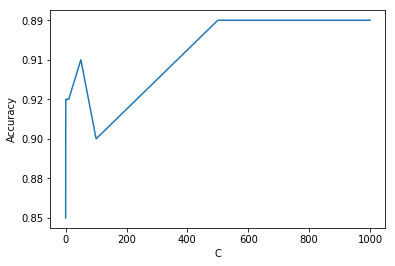



+-------------------------------------------------+
|      L1 Regularization with 'GridSearchCV'      |
+--------------------+----------+------+----------+
| Hyperparameter (C) | Scoring  | Mean | Variance |
+--------------------+----------+------+----------+
|       0.0001       | Accuracy | 0.85 |   0.03   |
|       0.0005       | Accuracy | 0.85 |   0.03   |
|       0.001        | Accuracy | 0.85 |   0.03   |
|       0.005        | Accuracy | 0.85 |   0.03   |
|        0.01        | Accuracy | 0.85 |   0.02   |
|        0.05        | Accuracy | 0.88 |   0.01   |
|        0.1         | Accuracy | 0.90 |   0.01   |
|        0.5         | Accuracy | 0.92 |   0.00   |
|         1          | Accuracy | 0.92 |   0.00   |
|         5          | Accuracy | 0.92 |   0.00   |
|         10         | Accuracy | 0.92 |   0.00   |
|         50         | Accuracy | 0.91 |   0.01   |
|        100         | Accuracy | 0.90 |   0.01   |
|        500         | Accuracy | 0.89 |   0.02   |
|        1

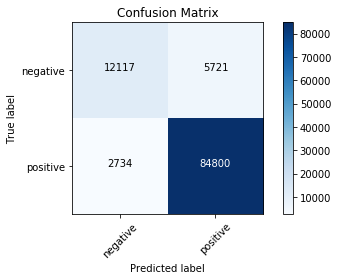


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 84800  |
|           TN (True Negative)           | 12117  |
|          FP (False Positive)           |  5721  |
|          FN (False Negative)           |  2734  |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.68  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.32  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 91.98% |
+----------------------------------------+--------+


-------------------------- RandomizedSearchCV --------------------------



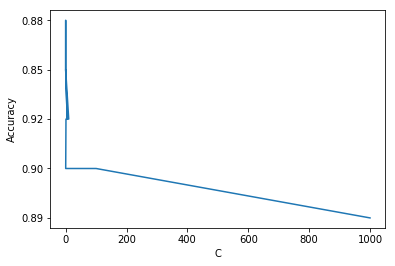



+-------------------------------------------------+
|   L1 Regularization with 'RandomizedSearchCV'   |
+--------------------+----------+------+----------+
| Hyperparameter (C) | Scoring  | Mean | Variance |
+--------------------+----------+------+----------+
|        1000        | Accuracy | 0.89 |   0.02   |
|        100         | Accuracy | 0.90 |   0.01   |
|        0.1         | Accuracy | 0.90 |   0.01   |
|         1          | Accuracy | 0.92 |   0.00   |
|         10         | Accuracy | 0.92 |   0.00   |
|       0.0005       | Accuracy | 0.85 |   0.03   |
|         5          | Accuracy | 0.92 |   0.00   |
|       0.001        | Accuracy | 0.85 |   0.03   |
|        0.05        | Accuracy | 0.88 |   0.01   |
|        0.01        | Accuracy | 0.85 |   0.02   |
+--------------------+----------+------+----------+

+--------------------------------------------------------------------------------+
|                Optimal hyperparameter & Testing accuracy score                 |

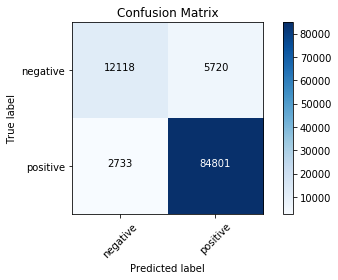


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 84801  |
|           TN (True Negative)           | 12118  |
|          FP (False Positive)           |  5720  |
|          FN (False Negative)           |  2733  |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.68  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.32  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 91.98% |
+----------------------------------------+--------+






*****************************************************************************
----------------------------- L2 Regularizaion -----------------------------
**********************************************************

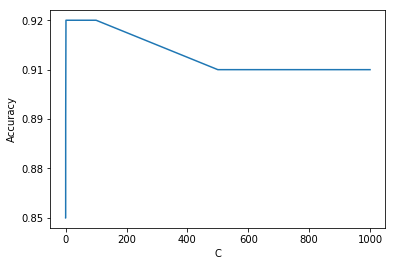



+-------------------------------------------------+
|      L2 Regularization with 'GridSearchCV'      |
+--------------------+----------+------+----------+
| Hyperparameter (C) | Scoring  | Mean | Variance |
+--------------------+----------+------+----------+
|       0.0001       | Accuracy | 0.85 |   0.03   |
|       0.0005       | Accuracy | 0.85 |   0.03   |
|       0.001        | Accuracy | 0.85 |   0.03   |
|       0.005        | Accuracy | 0.85 |   0.03   |
|        0.01        | Accuracy | 0.85 |   0.02   |
|        0.05        | Accuracy | 0.88 |   0.01   |
|        0.1         | Accuracy | 0.89 |   0.01   |
|        0.5         | Accuracy | 0.91 |   0.01   |
|         1          | Accuracy | 0.92 |   0.00   |
|         5          | Accuracy | 0.92 |   0.00   |
|         10         | Accuracy | 0.92 |   0.00   |
|         50         | Accuracy | 0.92 |   0.00   |
|        100         | Accuracy | 0.92 |   0.00   |
|        500         | Accuracy | 0.91 |   0.01   |
|        1

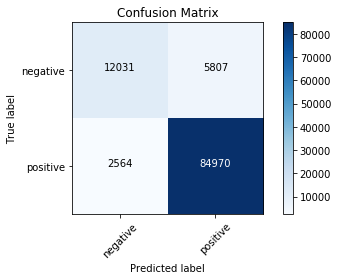


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 84970  |
|           TN (True Negative)           | 12031  |
|          FP (False Positive)           |  5807  |
|          FN (False Negative)           |  2564  |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.67  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.33  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 92.06% |
+----------------------------------------+--------+


-------------------------- RandomizedSearchCV --------------------------



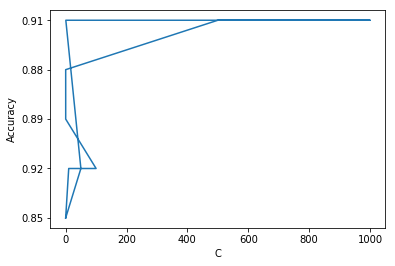



+-------------------------------------------------+
|   L2 Regularization with 'RandomizedSearchCV'   |
+--------------------+----------+------+----------+
| Hyperparameter (C) | Scoring  | Mean | Variance |
+--------------------+----------+------+----------+
|       0.0001       | Accuracy | 0.85 |   0.03   |
|         10         | Accuracy | 0.92 |   0.00   |
|        100         | Accuracy | 0.92 |   0.00   |
|        0.1         | Accuracy | 0.89 |   0.01   |
|        0.05        | Accuracy | 0.88 |   0.01   |
|        500         | Accuracy | 0.91 |   0.01   |
|        1000        | Accuracy | 0.91 |   0.01   |
|        0.5         | Accuracy | 0.91 |   0.01   |
|         50         | Accuracy | 0.92 |   0.00   |
|       0.0005       | Accuracy | 0.85 |   0.03   |
+--------------------+----------+------+----------+

+--------------------------------------------------------------------------------+
|                Optimal hyperparameter & Testing accuracy score                 |

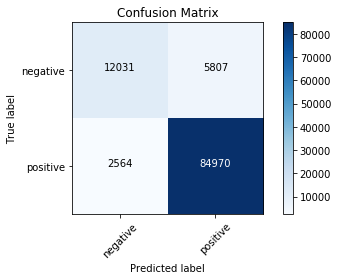


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 84970  |
|           TN (True Negative)           | 12031  |
|          FP (False Positive)           |  5807  |
|          FN (False Negative)           |  2564  |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.67  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.33  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 92.06% |
+----------------------------------------+--------+




Wall time: 10min 44s


In [12]:
%%time

# Perform logistic regression with l1 and l2 as a penalty, on bow
try:    
    run_logistic_regression("bow",
                            x_train = bow_train_features, 
                            x_test = bow_test_features, 
                            y_train = y_train,
                            y_test = y_test)  
except Exception:
    traceback.print_exc()

#### (3.2) Logistic regression on TF-IDF :



*****************************************************************************
----------------------------- L1 Regularizaion -----------------------------
*******************************************************************************


-------------------------- GridSearchCV --------------------------



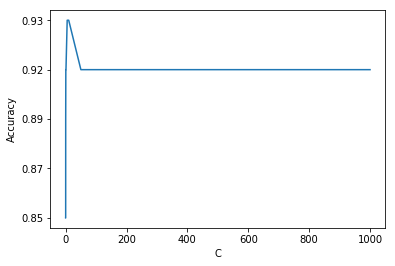



+-------------------------------------------------+
|      L1 Regularization with 'GridSearchCV'      |
+--------------------+----------+------+----------+
| Hyperparameter (C) | Scoring  | Mean | Variance |
+--------------------+----------+------+----------+
|       0.0001       | Accuracy | 0.85 |   0.03   |
|       0.0005       | Accuracy | 0.85 |   0.03   |
|       0.001        | Accuracy | 0.85 |   0.03   |
|       0.005        | Accuracy | 0.85 |   0.03   |
|        0.01        | Accuracy | 0.85 |   0.03   |
|        0.05        | Accuracy | 0.87 |   0.01   |
|        0.1         | Accuracy | 0.89 |   0.02   |
|        0.5         | Accuracy | 0.92 |   0.01   |
|         1          | Accuracy | 0.92 |   0.01   |
|         5          | Accuracy | 0.93 |   0.00   |
|         10         | Accuracy | 0.93 |   0.00   |
|         50         | Accuracy | 0.92 |   0.00   |
|        100         | Accuracy | 0.92 |   0.00   |
|        500         | Accuracy | 0.92 |   0.00   |
|        1

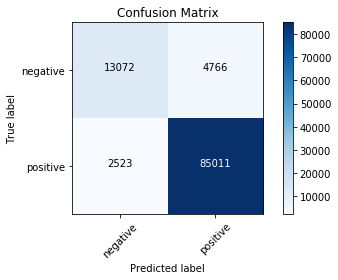


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 85011  |
|           TN (True Negative)           | 13072  |
|          FP (False Positive)           |  4766  |
|          FN (False Negative)           |  2523  |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.73  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.27  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 93.08% |
+----------------------------------------+--------+


-------------------------- RandomizedSearchCV --------------------------



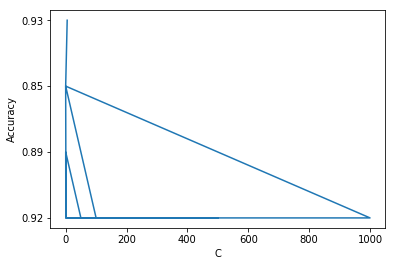



+-------------------------------------------------+
|   L1 Regularization with 'RandomizedSearchCV'   |
+--------------------+----------+------+----------+
| Hyperparameter (C) | Scoring  | Mean | Variance |
+--------------------+----------+------+----------+
|         50         | Accuracy | 0.92 |   0.00   |
|        0.1         | Accuracy | 0.89 |   0.02   |
|        0.5         | Accuracy | 0.92 |   0.01   |
|        1000        | Accuracy | 0.92 |   0.00   |
|       0.0005       | Accuracy | 0.85 |   0.03   |
|        100         | Accuracy | 0.92 |   0.00   |
|        500         | Accuracy | 0.92 |   0.00   |
|         1          | Accuracy | 0.92 |   0.01   |
|       0.0001       | Accuracy | 0.85 |   0.03   |
|         5          | Accuracy | 0.93 |   0.00   |
+--------------------+----------+------+----------+

+--------------------------------------------------------------------------------+
|                Optimal hyperparameter & Testing accuracy score                 |

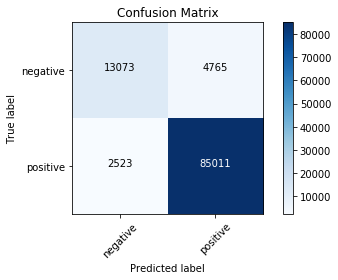


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 85011  |
|           TN (True Negative)           | 13073  |
|          FP (False Positive)           |  4765  |
|          FN (False Negative)           |  2523  |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.73  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.27  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 93.08% |
+----------------------------------------+--------+






*****************************************************************************
----------------------------- L2 Regularizaion -----------------------------
**********************************************************

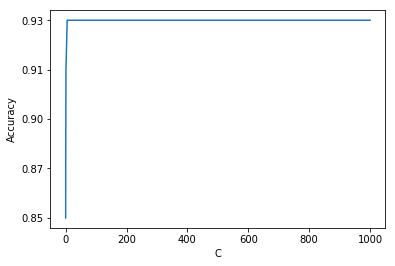



+-------------------------------------------------+
|      L2 Regularization with 'GridSearchCV'      |
+--------------------+----------+------+----------+
| Hyperparameter (C) | Scoring  | Mean | Variance |
+--------------------+----------+------+----------+
|       0.0001       | Accuracy | 0.85 |   0.03   |
|       0.0005       | Accuracy | 0.85 |   0.03   |
|       0.001        | Accuracy | 0.85 |   0.03   |
|       0.005        | Accuracy | 0.85 |   0.03   |
|        0.01        | Accuracy | 0.85 |   0.03   |
|        0.05        | Accuracy | 0.85 |   0.02   |
|        0.1         | Accuracy | 0.87 |   0.02   |
|        0.5         | Accuracy | 0.90 |   0.02   |
|         1          | Accuracy | 0.91 |   0.02   |
|         5          | Accuracy | 0.93 |   0.01   |
|         10         | Accuracy | 0.93 |   0.01   |
|         50         | Accuracy | 0.93 |   0.00   |
|        100         | Accuracy | 0.93 |   0.00   |
|        500         | Accuracy | 0.93 |   0.00   |
|        1

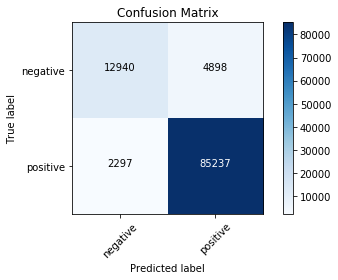


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 85237  |
|           TN (True Negative)           | 12940  |
|          FP (False Positive)           |  4898  |
|          FN (False Negative)           |  2297  |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.73  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.27  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 93.17% |
+----------------------------------------+--------+


-------------------------- RandomizedSearchCV --------------------------



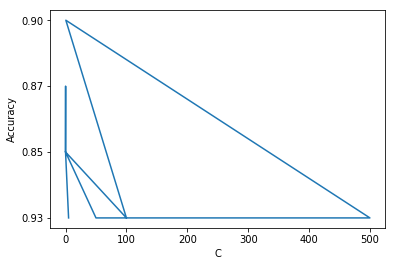



+-------------------------------------------------+
|   L2 Regularization with 'RandomizedSearchCV'   |
+--------------------+----------+------+----------+
| Hyperparameter (C) | Scoring  | Mean | Variance |
+--------------------+----------+------+----------+
|         5          | Accuracy | 0.93 |   0.01   |
|       0.001        | Accuracy | 0.85 |   0.03   |
|        0.01        | Accuracy | 0.85 |   0.03   |
|        0.1         | Accuracy | 0.87 |   0.02   |
|       0.005        | Accuracy | 0.85 |   0.03   |
|        100         | Accuracy | 0.93 |   0.00   |
|        0.5         | Accuracy | 0.90 |   0.02   |
|        500         | Accuracy | 0.93 |   0.00   |
|         50         | Accuracy | 0.93 |   0.00   |
|       0.0005       | Accuracy | 0.85 |   0.03   |
+--------------------+----------+------+----------+

+--------------------------------------------------------------------------------+
|                Optimal hyperparameter & Testing accuracy score                 |

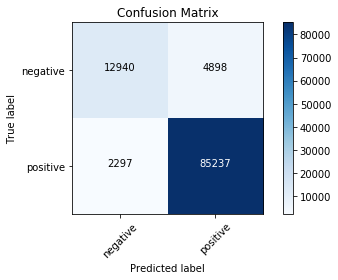


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 85237  |
|           TN (True Negative)           | 12940  |
|          FP (False Positive)           |  4898  |
|          FN (False Negative)           |  2297  |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.73  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.27  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 93.17% |
+----------------------------------------+--------+




Wall time: 11min 7s


In [13]:
%%time

# Perform logistic regression with l1 and l2 as a penalty, on TF-IDF
try:    
    run_logistic_regression("tf-idf",
                            x_train = tf_idf_train_features, 
                            x_test = tf_idf_test_features, 
                            y_train = y_train,
                            y_test = y_test)  
except Exception:
    traceback.print_exc()

#### (3.3) Logistic regression on Average Word2Vec :



*****************************************************************************
----------------------------- L1 Regularizaion -----------------------------
*******************************************************************************


-------------------------- GridSearchCV --------------------------



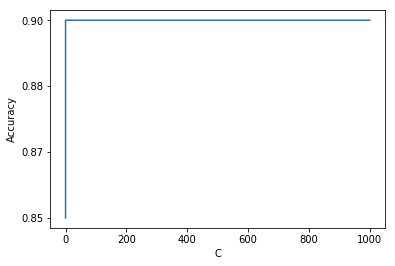



+-------------------------------------------------+
|      L1 Regularization with 'GridSearchCV'      |
+--------------------+----------+------+----------+
| Hyperparameter (C) | Scoring  | Mean | Variance |
+--------------------+----------+------+----------+
|       0.0001       | Accuracy | 0.85 |   0.03   |
|       0.0005       | Accuracy | 0.85 |   0.03   |
|       0.001        | Accuracy | 0.85 |   0.03   |
|       0.005        | Accuracy | 0.87 |   0.01   |
|        0.01        | Accuracy | 0.88 |   0.00   |
|        0.05        | Accuracy | 0.90 |   0.01   |
|        0.1         | Accuracy | 0.90 |   0.01   |
|        0.5         | Accuracy | 0.90 |   0.01   |
|         1          | Accuracy | 0.90 |   0.01   |
|         5          | Accuracy | 0.90 |   0.01   |
|         10         | Accuracy | 0.90 |   0.01   |
|         50         | Accuracy | 0.90 |   0.01   |
|        100         | Accuracy | 0.90 |   0.01   |
|        500         | Accuracy | 0.90 |   0.01   |
|        1

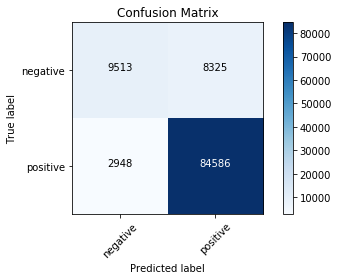


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 84586  |
|           TN (True Negative)           |  9513  |
|          FP (False Positive)           |  8325  |
|          FN (False Negative)           |  2948  |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.53  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.47  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 89.30% |
+----------------------------------------+--------+


-------------------------- RandomizedSearchCV --------------------------



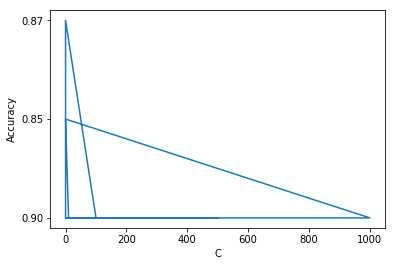



+-------------------------------------------------+
|   L1 Regularization with 'RandomizedSearchCV'   |
+--------------------+----------+------+----------+
| Hyperparameter (C) | Scoring  | Mean | Variance |
+--------------------+----------+------+----------+
|        0.5         | Accuracy | 0.90 |   0.01   |
|        500         | Accuracy | 0.90 |   0.01   |
|         50         | Accuracy | 0.90 |   0.01   |
|         10         | Accuracy | 0.90 |   0.01   |
|       0.0001       | Accuracy | 0.85 |   0.03   |
|       0.0005       | Accuracy | 0.85 |   0.03   |
|        1000        | Accuracy | 0.90 |   0.01   |
|        0.1         | Accuracy | 0.90 |   0.01   |
|       0.005        | Accuracy | 0.87 |   0.01   |
|        100         | Accuracy | 0.90 |   0.01   |
+--------------------+----------+------+----------+

+--------------------------------------------------------------------------------+
|                Optimal hyperparameter & Testing accuracy score                 |

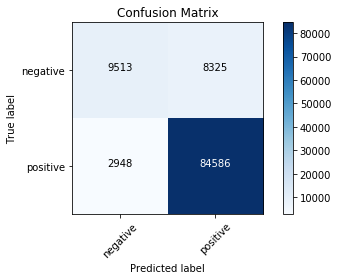


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 84586  |
|           TN (True Negative)           |  9513  |
|          FP (False Positive)           |  8325  |
|          FN (False Negative)           |  2948  |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.53  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.47  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 89.30% |
+----------------------------------------+--------+






*****************************************************************************
----------------------------- L2 Regularizaion -----------------------------
**********************************************************

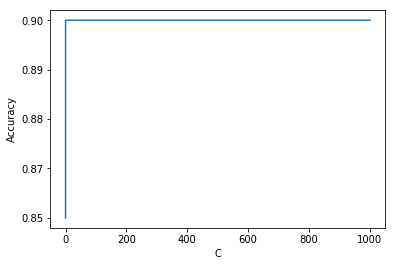



+-------------------------------------------------+
|      L2 Regularization with 'GridSearchCV'      |
+--------------------+----------+------+----------+
| Hyperparameter (C) | Scoring  | Mean | Variance |
+--------------------+----------+------+----------+
|       0.0001       | Accuracy | 0.85 |   0.03   |
|       0.0005       | Accuracy | 0.85 |   0.03   |
|       0.001        | Accuracy | 0.85 |   0.03   |
|       0.005        | Accuracy | 0.87 |   0.01   |
|        0.01        | Accuracy | 0.88 |   0.00   |
|        0.05        | Accuracy | 0.89 |   0.01   |
|        0.1         | Accuracy | 0.90 |   0.01   |
|        0.5         | Accuracy | 0.90 |   0.01   |
|         1          | Accuracy | 0.90 |   0.01   |
|         5          | Accuracy | 0.90 |   0.01   |
|         10         | Accuracy | 0.90 |   0.01   |
|         50         | Accuracy | 0.90 |   0.01   |
|        100         | Accuracy | 0.90 |   0.01   |
|        500         | Accuracy | 0.90 |   0.01   |
|        1

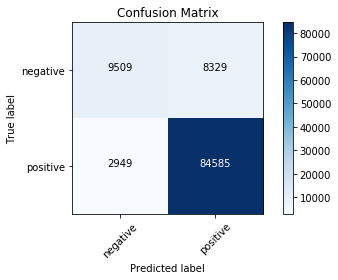


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 84585  |
|           TN (True Negative)           |  9509  |
|          FP (False Positive)           |  8329  |
|          FN (False Negative)           |  2949  |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.53  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.47  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 89.30% |
+----------------------------------------+--------+


-------------------------- RandomizedSearchCV --------------------------



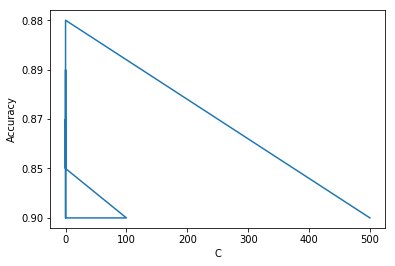



+-------------------------------------------------+
|   L2 Regularization with 'RandomizedSearchCV'   |
+--------------------+----------+------+----------+
| Hyperparameter (C) | Scoring  | Mean | Variance |
+--------------------+----------+------+----------+
|        0.5         | Accuracy | 0.90 |   0.01   |
|        100         | Accuracy | 0.90 |   0.01   |
|       0.001        | Accuracy | 0.85 |   0.03   |
|       0.0005       | Accuracy | 0.85 |   0.03   |
|       0.005        | Accuracy | 0.87 |   0.01   |
|        0.1         | Accuracy | 0.90 |   0.01   |
|        0.05        | Accuracy | 0.89 |   0.01   |
|       0.0001       | Accuracy | 0.85 |   0.03   |
|        0.01        | Accuracy | 0.88 |   0.00   |
|        500         | Accuracy | 0.90 |   0.01   |
+--------------------+----------+------+----------+

+--------------------------------------------------------------------------------+
|                Optimal hyperparameter & Testing accuracy score                 |

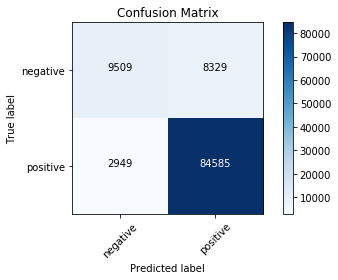


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 84585  |
|           TN (True Negative)           |  9509  |
|          FP (False Positive)           |  8329  |
|          FN (False Negative)           |  2949  |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.53  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.47  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 89.30% |
+----------------------------------------+--------+




Wall time: 6min 46s


In [14]:
%%time

# Perform logistic regression with l1 and l2 as a penalty, on average word2vec
try:
    run_logistic_regression("avg-w2v",
                            x_train = avg_w2v_train, 
                            x_test = avg_w2v_test, 
                            y_train = y_train,
                            y_test = y_test)  
except Exception:
    traceback.print_exc()

#### (3.4) Logistic regression on TF-IDF weighted Word2Vec :



*****************************************************************************
----------------------------- L1 Regularizaion -----------------------------
*******************************************************************************


-------------------------- GridSearchCV --------------------------



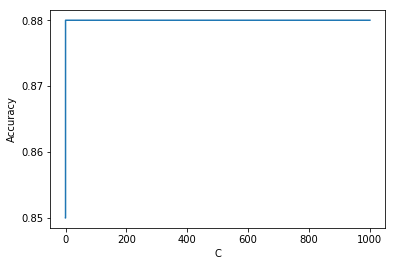



+-------------------------------------------------+
|      L1 Regularization with 'GridSearchCV'      |
+--------------------+----------+------+----------+
| Hyperparameter (C) | Scoring  | Mean | Variance |
+--------------------+----------+------+----------+
|       0.0001       | Accuracy | 0.85 |   0.03   |
|       0.0005       | Accuracy | 0.85 |   0.03   |
|       0.001        | Accuracy | 0.85 |   0.03   |
|       0.005        | Accuracy | 0.86 |   0.01   |
|        0.01        | Accuracy | 0.87 |   0.00   |
|        0.05        | Accuracy | 0.88 |   0.01   |
|        0.1         | Accuracy | 0.88 |   0.02   |
|        0.5         | Accuracy | 0.88 |   0.02   |
|         1          | Accuracy | 0.88 |   0.02   |
|         5          | Accuracy | 0.88 |   0.02   |
|         10         | Accuracy | 0.88 |   0.02   |
|         50         | Accuracy | 0.88 |   0.02   |
|        100         | Accuracy | 0.88 |   0.02   |
|        500         | Accuracy | 0.88 |   0.02   |
|        1

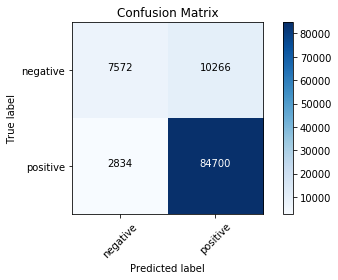


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 84700  |
|           TN (True Negative)           |  7572  |
|          FP (False Positive)           | 10266  |
|          FN (False Negative)           |  2834  |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.42  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.58  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 87.57% |
+----------------------------------------+--------+


-------------------------- RandomizedSearchCV --------------------------



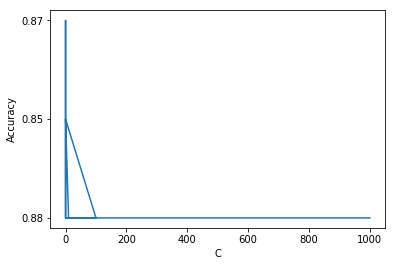



+-------------------------------------------------+
|   L1 Regularization with 'RandomizedSearchCV'   |
+--------------------+----------+------+----------+
| Hyperparameter (C) | Scoring  | Mean | Variance |
+--------------------+----------+------+----------+
|         50         | Accuracy | 0.88 |   0.02   |
|         1          | Accuracy | 0.88 |   0.02   |
|        100         | Accuracy | 0.88 |   0.02   |
|       0.001        | Accuracy | 0.85 |   0.03   |
|       0.0001       | Accuracy | 0.85 |   0.03   |
|         10         | Accuracy | 0.88 |   0.02   |
|        0.1         | Accuracy | 0.88 |   0.02   |
|        0.01        | Accuracy | 0.87 |   0.00   |
|        0.05        | Accuracy | 0.88 |   0.01   |
|        1000        | Accuracy | 0.88 |   0.02   |
+--------------------+----------+------+----------+

+--------------------------------------------------------------------------------+
|                Optimal hyperparameter & Testing accuracy score                 |

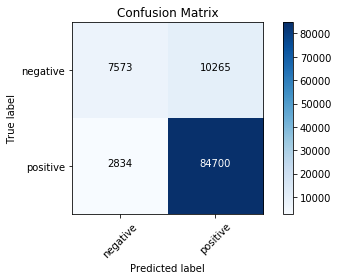


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 84700  |
|           TN (True Negative)           |  7573  |
|          FP (False Positive)           | 10265  |
|          FN (False Negative)           |  2834  |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.42  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.58  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 87.57% |
+----------------------------------------+--------+






*****************************************************************************
----------------------------- L2 Regularizaion -----------------------------
**********************************************************

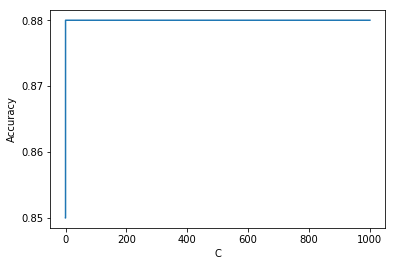



+-------------------------------------------------+
|      L2 Regularization with 'GridSearchCV'      |
+--------------------+----------+------+----------+
| Hyperparameter (C) | Scoring  | Mean | Variance |
+--------------------+----------+------+----------+
|       0.0001       | Accuracy | 0.85 |   0.03   |
|       0.0005       | Accuracy | 0.85 |   0.03   |
|       0.001        | Accuracy | 0.85 |   0.03   |
|       0.005        | Accuracy | 0.86 |   0.01   |
|        0.01        | Accuracy | 0.87 |   0.01   |
|        0.05        | Accuracy | 0.88 |   0.01   |
|        0.1         | Accuracy | 0.88 |   0.01   |
|        0.5         | Accuracy | 0.88 |   0.02   |
|         1          | Accuracy | 0.88 |   0.02   |
|         5          | Accuracy | 0.88 |   0.02   |
|         10         | Accuracy | 0.88 |   0.02   |
|         50         | Accuracy | 0.88 |   0.02   |
|        100         | Accuracy | 0.88 |   0.02   |
|        500         | Accuracy | 0.88 |   0.02   |
|        1

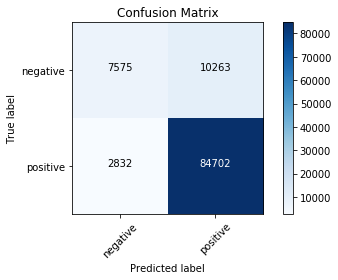


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 84702  |
|           TN (True Negative)           |  7575  |
|          FP (False Positive)           | 10263  |
|          FN (False Negative)           |  2832  |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.42  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.58  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 87.57% |
+----------------------------------------+--------+


-------------------------- RandomizedSearchCV --------------------------



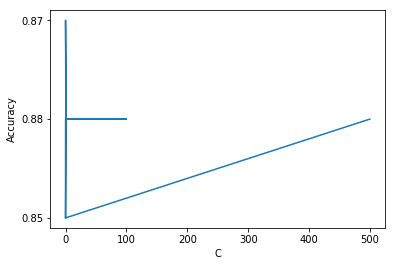



+-------------------------------------------------+
|   L2 Regularization with 'RandomizedSearchCV'   |
+--------------------+----------+------+----------+
| Hyperparameter (C) | Scoring  | Mean | Variance |
+--------------------+----------+------+----------+
|       0.001        | Accuracy | 0.85 |   0.03   |
|         1          | Accuracy | 0.88 |   0.02   |
|        0.01        | Accuracy | 0.87 |   0.01   |
|        0.5         | Accuracy | 0.88 |   0.02   |
|        100         | Accuracy | 0.88 |   0.02   |
|        0.1         | Accuracy | 0.88 |   0.01   |
|        0.05        | Accuracy | 0.88 |   0.01   |
|       0.0001       | Accuracy | 0.85 |   0.03   |
|       0.0005       | Accuracy | 0.85 |   0.03   |
|        500         | Accuracy | 0.88 |   0.02   |
+--------------------+----------+------+----------+

+--------------------------------------------------------------------------------+
|                Optimal hyperparameter & Testing accuracy score                 |

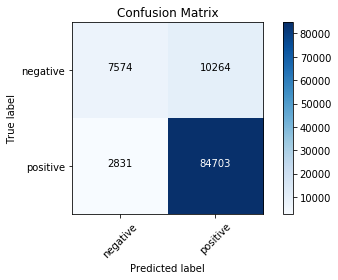


+-------------------------------------------------+
|             Confusion Matrix Report             |
+----------------------------------------+--------+
|                  Term                  | Value  |
+----------------------------------------+--------+
|           TP (True Positive)           | 84703  |
|           TN (True Negative)           |  7574  |
|          FP (False Positive)           | 10264  |
|          FN (False Negative)           |  2831  |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.97  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.42  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.58  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.03  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 87.57% |
+----------------------------------------+--------+




Wall time: 6min 26s


In [15]:
%%time

# Perform logistic regression with l1 and l2 as a penalty, on tf-idf weighted Word2Vec
try:    
    run_logistic_regression("tf-idf-w2v",
                            x_train = tfidf_w2v_train,
                            x_test = tfidf_w2v_test, 
                            y_train = y_train,
                            y_test = y_test)
except Exception:
    traceback.print_exc()

<br/><br/>

### (3) Calculate sparsity on weight vector using L1 regularization :

In [16]:
classifier = LogisticRegression()
classifier.penalty = 'l1'

#### (3.1) Sparsity testing using BoW : 
Task : Keep increasing and decreasing lambda(1 / C), to calculate error and sparsity.

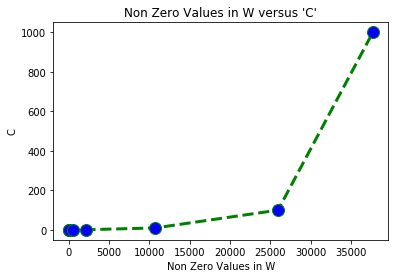

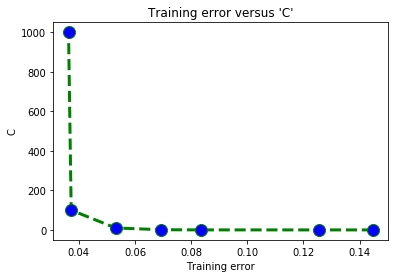



+-----------------------------------------------+
|            Sparsity Testing Report            |
+-------------------+----------+----------------+
| Hyperparameter(C) | Sparsity | Training Error |
+-------------------+----------+----------------+
|       0.001       |    2     |      0.14      |
|        0.01       |    72    |      0.13      |
|        0.1        |   505    |      0.08      |
|         1         |   2166   |      0.07      |
|         10        |  10720   |      0.05      |
|        100        |  25947   |      0.04      |
|        1000       |  37703   |      0.04      |
+-------------------+----------+----------------+

Wall time: 36.4 s


In [17]:
%%time

# perform sparsity testing on bow
perform_sparsity_testing(classifier,bow_train_features)

#### As we can observe from the table that,when we increase hyperparameter's value, sparsity of weight vector increases drastically. 


<br/><br/>

### (4) Perform multicollinearity (pertubation test) on features and show feature importance :
#### (4.1) Pertubation test  using BoW: 

In [18]:
# Check for multicollinearity on Bow
weight_before_pertubation,weight_after_pertubation,clf_bow = perform_pertubation_test(bow_train_features,
                                                                                      bow_test_features,
                                                                                      y_train,
                                                                                      y_test,
                                                                                      10,
                                                                                      "l2")

count_nnz_w1 = np.count_nonzero(weight_before_pertubation != 0)
count_nnz_w2 = np.count_nonzero(weight_after_pertubation != 0)

if(count_nnz_w1 == 0):
    print("\nWeight vector has 0 number of non zero alements.") 
    print("Features are highly collinear in nature.")    
elif(count_nnz_w1 == count_nnz_w2 and count_nnz_w1 != 0):
    # Compare weight vectors for tolerence value
    # For tolerence value check for numpy.isclose() documentation
    compare_weight_vectors(weight_before_pertubation, weight_after_pertubation, 0.001)
    print("\nFeatures are non collinear for tolerence value 0.001")
    print("As we decrease tolerence value and increase noise, features may become multicollinear.")
else:
    print("\nFeatures are highly collinear in nature.")
    print("After adding the noise, {0} of non zero elements changes drastically.".format(abs(count_nnz_w1 - count_nnz_w2)))

------------------ Before Pertubation Test ------------------
Accuracy on testing data: 88.54%
Number of non zero weights in weight vector 'w':  74398


------------------ After Pertubation Test ------------------
Accuracy on testing data: 88.54%
Number of non zero weights in weight vector 'w':  74398


5.01% value changes with tolerence value of 0.001 between two weight vectors


Features are non collinear for tolerence value 0.001
As we decrease tolerence value and increase noise, features may become multicollinear.


#### Feature importance for BoW: 

In [19]:
# Get most common features based on absolute value of weight vectors for positive and negative reviews.
get_most_common_words(clf_bow, bow_vectorizer, top_n=25)


+-----------------------------------------------------------------------------+
|    Feature Importance - 25 Most Common Features using absolute value of W   |
+----------------+---------------------+----------------+---------------------+
| Feature (+ve)  |      |W| (+ve)      | Feature (-ve)  |      |W| (-ve)      |
+----------------+---------------------+----------------+---------------------+
|    skeptic     |  14.093841521131703 |     worst      |  18.622891313261203 |
|    downsid     |   12.4193682373266  |    undrink     |  13.921291319297751 |
|      hook      |   11.8752691044259  |    mediocr     |  13.404212464786815 |
|    drawback    |  10.739237103699683 |       aw       |  12.548249483460532 |
|      yum       |  10.133941063043544 |    disgust     |  12.212535927662982 |
|      beat      |  9.950258878259177  |    terribl     |  11.930148162984606 |
|     addict     |  9.933788089974016  |   flavorless   |  11.704998305667674 |
|      yay       |  9.853897813765265  

<br/>

#### (4.2) Pertubation test  using TF-IDF: 

In [20]:
# Check for multicollinearity on TF-IDF
weight_before_pertubation,weight_after_pertubation,clf_tfidf = perform_pertubation_test(tf_idf_train_features,
                                                                                        tf_idf_test_features,
                                                                                        y_train,
                                                                                        y_test,
                                                                                        100,
                                                                                        "l2")

count_nnz_w1 = np.count_nonzero(weight_before_pertubation != 0)
count_nnz_w2 = np.count_nonzero(weight_after_pertubation != 0)

if(count_nnz_w1 == 0):
    print("\nWeight vector has 0 number of non zero alements.") 
    print("Features are highly collinear in nature.")    
elif(count_nnz_w1 == count_nnz_w2 and count_nnz_w1 != 0):
    # Compare weight vectors for tolerence value
    # For tolerence value check for numpy.isclose() documentation
    compare_weight_vectors(weight_before_pertubation, weight_after_pertubation, 0.001)
    print("\nFeatures are non collinear for tolerence value 0.001")
    print("As we decrease tolerence value and increase noise, features may become multicollinear.")
else:
    print("\nFeatures are highly collinear in nature.")
    print("After adding the noise, {0} of non zero elements changes drastically.".format(abs(count_nnz_w1 - count_nnz_w2)))

------------------ Before Pertubation Test ------------------
Accuracy on testing data: 92.97%
Number of non zero weights in weight vector 'w':  487621


------------------ After Pertubation Test ------------------
Accuracy on testing data: 92.97%
Number of non zero weights in weight vector 'w':  487621


18.49% value changes with tolerence value of 0.001 between two weight vectors


Features are non collinear for tolerence value 0.001
As we decrease tolerence value and increase noise, features may become multicollinear.


#### Feature importance for TF-IDF: 

In [21]:
# Get most common features based on absolute value of weight vectors for positive and negative reviews.
get_most_common_words(clf_tfidf, tfidf_vectorizer, top_n=25)


+-----------------------------------------------------------------------------+
|    Feature Importance - 25 Most Common Features using absolute value of W   |
+------------------+--------------------+----------------+--------------------+
|  Feature (+ve)   |     |W| (+ve)      | Feature (-ve)  |     |W| (-ve)      |
+------------------+--------------------+----------------+--------------------+
|      great       | 35.71753722234398  |    two star    | 36.03427893987466  |
|      delici      | 33.90030035531667  |     worst      | 33.408742132252534 |
|  high recommend  | 31.948761537248355 |   disappoint   | 30.34677939920822  |
|       best       | 28.740551312314132 |       aw       | 24.97421765228579  |
|     perfect      | 28.608983960336065 |    terribl     | 24.703196603437235 |
|       love       | 28.15723999115403  |    horribl     | 22.67822522092035  |
|      excel       | 26.266356006723967 |    disgust     | 21.02086539348089  |
| wont disappoint  | 24.801194120737186

<br/>

#### (4.3) Pertubation test  using Average Word2Vec: 

In [22]:
# Check for multicollinearity on Bow
weight_before_pertubation,weight_after_pertubation,ignore = perform_pertubation_test(avg_w2v_train,
                                                                                avg_w2v_test,
                                                                                y_train,
                                                                                y_test,
                                                                                100,
                                                                                "l2")

count_nnz_w1 = np.count_nonzero(weight_before_pertubation != 0)
count_nnz_w2 = np.count_nonzero(weight_after_pertubation != 0)

if(count_nnz_w1 == 0):
    print("\nWeight vector has 0 number of non zero alements.") 
    print("Features are highly collinear in nature.")    
elif(count_nnz_w1 == count_nnz_w2 and count_nnz_w1 != 0):
    # Compare weight vectors for tolerence value
    # For tolerence value check for numpy.isclose() documentation
    compare_weight_vectors(weight_before_pertubation, weight_after_pertubation, 0.001)
else:
    print("\nFeatures are highly collinear in nature.")
    print("After adding the noise, {0} of non zero elements changes drastically.".format(abs(count_nnz_w1 - count_nnz_w2)))

------------------ Before Pertubation Test ------------------
Accuracy on testing data: 82.66%
Number of non zero weights in weight vector 'w':  50


------------------ After Pertubation Test ------------------
Accuracy on testing data: 82.66%
Number of non zero weights in weight vector 'w':  50


0.00% value changes with tolerence value of 0.001 between two weight vectors



<br/>

#### (4.4) Pertubation test  using TF-IDF Weighted Word2Vec: 

In [24]:
# Check for multicollinearity on Bow
weight_before_pertubation,weight_after_pertubation,ignore = perform_pertubation_test(tfidf_w2v_train,
                                                                                tfidf_w2v_test,
                                                                                y_train,
                                                                                y_test,
                                                                                50,
                                                                                "l1")


count_nnz_w1 = np.count_nonzero(weight_before_pertubation != 0)
count_nnz_w2 = np.count_nonzero(weight_after_pertubation != 0)

if(count_nnz_w1 == 0):
    print("\nWeight vector has 0 number of non zero alements.") 
    print("Features are highly collinear in nature.")    
elif(count_nnz_w1 == count_nnz_w2 and count_nnz_w1 != 0):
    # Compare weight vectors for tolerence value
    # For tolerence value check for numpy.isclose() documentation
    compare_weight_vectors(weight_before_pertubation, weight_after_pertubation, 0.001)
else:
    print("\nFeatures are highly collinear in nature.")
    print("After adding the noise, {0} of non zero elements changes drastically.".format(abs(count_nnz_w1 - count_nnz_w2)))

------------------ Before Pertubation Test ------------------
Accuracy on testing data: 80.00%
Number of non zero weights in weight vector 'w':  50


------------------ After Pertubation Test ------------------
Accuracy on testing data: 80.00%
Number of non zero weights in weight vector 'w':  50


0.00% value changes with tolerence value of 0.001 between two weight vectors



---
### Conclusion :
---

In [25]:
conclude()

+----------------------------------------------------------------------------------------------+
|                                       ***Conclusion***                                       |
+--------------------+---------------------+----------------+-------------+--------------------+
|     Penalty-CV     |        Model        | Hyperparameter | Train Error |     Test Error     |
+--------------------+---------------------+----------------+-------------+--------------------+
|         L1         |         BOW         |       5        |     6.0%    |        8.0%        |
|    GridSearchCV    | Logistic Regression |                |             |                    |
|         L1         |         BOW         |       5        |     6.0%    |        8.0%        |
| RandomizedSearchCV | Logistic Regression |                |             |                    |
|         L2         |         BOW         |       10       |     6.0%    |        8.0%        |
|    GridSearchCV    | Logisti

---
### Observations :
---

> 1. Here, Logistic Regression classifier is applied on complete dataset(~364K).
> 2. Given dataset is imbalanced in nature (postive reviews:negative reviews = 5.57/1).
> 3. Grid search and Randomized search cross validation with 5-fold technique is applied to calculate optimal hyperparameter 'C'= 1/lambda.
> 4. Logistic regression produces very good result and sensible models on BoW & TF-IDF with ~92 and ~93 % accuracy.
> 5. For this dataset, it is observed that logistic regression does not perform well with Average Word2Vec and TF-IDF weighted Word2Vec, but accuracy can be increased by introducing rigorous topic modeling or trying out different classification techniques.
> 6. Sparsity testing is done, which evaluates that as you incease the values of 'C', number of zero values in the weight vector increases drastically.
> 7. Multicollinearity testing(Pertubation technique) is done, which evaluates that ,BoW produces good result and it is non collinear in nature.
> 8. for more information you can always refer to conclusion table above.